# Modelo de Kermack McKendrick

In [1]:
include("Taylor.jl")
using ADT
using PyPlot

Las ecuaciones diferenciales que rigen el modelo para una especie son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este modelo NO tomamos en cuenta los nacimientos y muertes, así que para una población fija se tiene que $ N = S(t) + I(t) + R(t)$ en todo tiempo.

In [2]:
function coefs_1(gamma, beta, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) # F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1 (generic function with 2 methods)

Error absoluto

In [3]:
eps_abs = 1e-50

1.0e-50

In [4]:
function paso(a::Taylor, p = 40)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

paso (generic function with 2 methods)

In [5]:
function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

ev_horner (generic function with 1 method)

In [6]:
function integrador_kermack(N, I0, R0, t0, tf, gamma, beta)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

integrador_kermack (generic function with 1 method)

In [7]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);
length(t)

  1.959312 seconds (43.87 M allocations: 726.011 MB, 2.68% gc time)


123

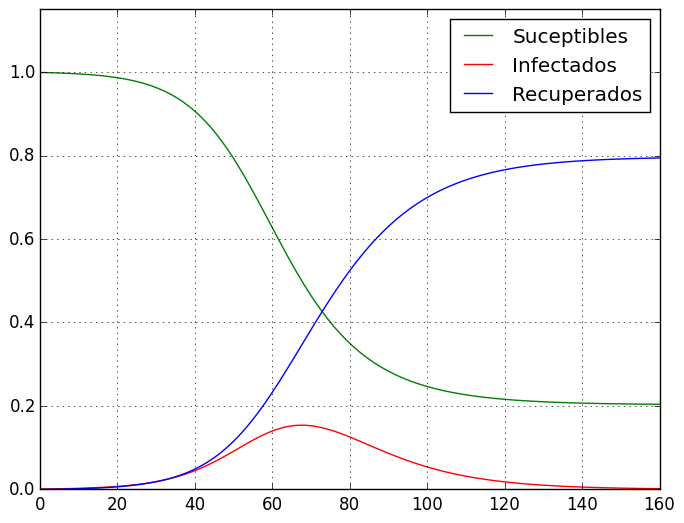

In [8]:
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,160,0,1.15])
grid()
legend()
show()

Ahora hagamos un diagrama fase de esto, donde no esperamos ningún comportamiento peculiar.

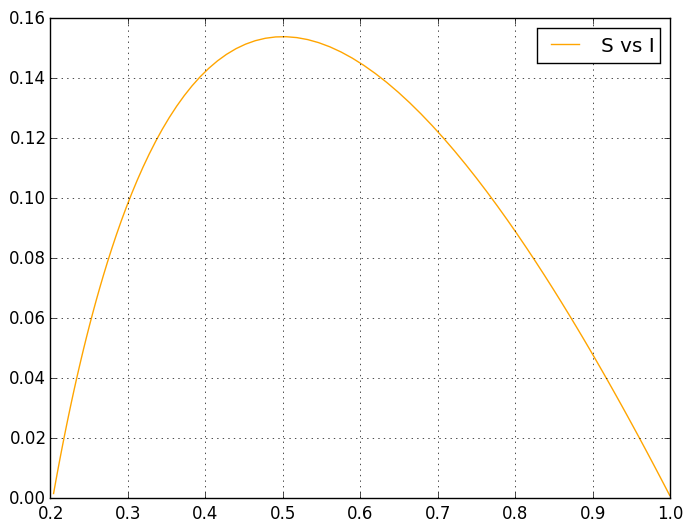

In [9]:
plot(s,i, color = "orange", label = "S vs I")
plot
legend()
grid()
show()

Ahora introducimos un término de reincidencia $\phi$, quedando las ecuaciones como:

$$ \frac{dS}{dt} = -\beta SI + \phi R$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I -\phi R$$
Como sigue, definimos nuestras funciones de coeficientes y el integrador.

In [10]:
function coefs_1_re(gamma, beta, phi, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    F3(R) = phi*R
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) + F3(Tr)# F1 = -b*S*I + p*R
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) - F3(Tr) # F2 = g*I-p*R

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1_re (generic function with 2 methods)

In [11]:
function integrador_kermack_re(N, I0, R0, t0, tf, gamma, beta, phi)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    n_iteraciones = 1
    while t0 < tf && n_iteraciones < 10000
        
        S,I,R = coefs_1_re(gamma, beta, phi, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
        n_iteraciones += 1
    end
    return t,s,i,r
end

integrador_kermack_re (generic function with 1 method)

Establecemos condiciones iniciales e integramos.

In [12]:
N = 1.
t_inicial = 0.
t_final = 1400.
beta = .5
gamma = .25
phi = 0.005
infectados_iniciales = N/1000
recuperados_iniciales = 0.

@time t,s,i,r = integrador_kermack_re(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta, phi);
length(t)

  7.620265 seconds (227.76 M allocations: 3.663 GB, 3.18% gc time)


639

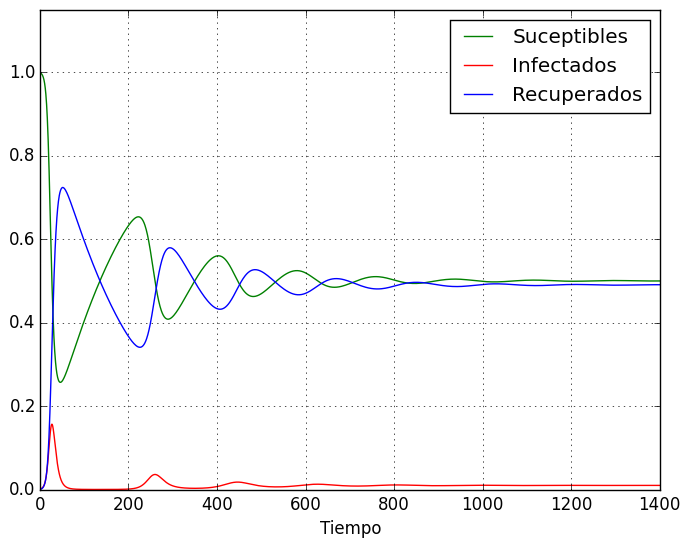

In [13]:
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,t_final,0,1.15])
grid()
legend()
xlabel("Tiempo")
show()

Dibujamos ahora el diagrama fase.

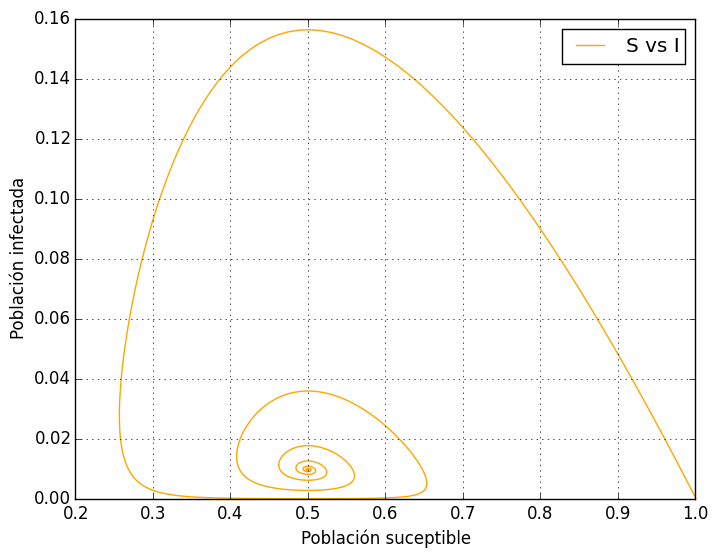

In [14]:
plot(s,i, color = "orange", label = "S vs I")
legend()
xlabel("Población suceptible")
ylabel("Población infectada")
grid()
show()

**Animación de la Solución**

Al inicial el programa debe ejecutar 2 veces la celda; la primera vez da error y la segunda muestra el video. El usar PyCall también interfiere con Pyplot asíque podría limpiarse el namespace para que no interfiriese con las celdas de abajo.

Para realizar la animación de un punto o curva que se mueve en el espacio se requieren 3 arrays: el tiempo t, los puntos de x como función de t y los puntos de y como función de t. Es decir que, si $t[i]=t_i$, entonces $x[i]=x(t=t_i)$ y lo mismo para y. Los tres deben ser de la misma longitud.

In [15]:
# Function for creating an embedded video given a filename. Saves it to the folder the notebook is currently placed
function html_video(filename)
    base64_video = base64(open(readbytes, filename))
    """<video controls src="data:video/x-m4v;base64,$base64_video">"""
end
#displays the video from the previously saved file. This has the advantage of keeping the notebook size small
display("text/html", html_video("Animaciones/primerSvsI.mp4"))

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAyidtZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCByMjY5NCAzYjcwNjQ1IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlyaWdodCAyMDAzLTIwMTYgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEQxliIQAL//+9q78yytHC5UuHVl7s1Hy6Ely/YgwfWgAAAMAAAMAAAMABVHrEQpsXdeGoAAAAwAX4AUVKvus9wBiAZMwTsbaN1vs6SZLa6gGEMlaKuxPaQRv4MuDq93agYM+iIwUOAsNd0G/24ZYfZry0c0GQYEvR7RznndStbNZF51kmwmGsDqteO5Pv9L5nmAqPkoce0hfo+Fu0TTWrAP2RMmd3vf1mDurq4O0xHlGlnsKTVAvCcGMjWMc813Ffgq5u5AWgGuCcNFH8/lghl7fdHfvhBspnvSj+eYoU4hKwoT5qtNm2qZuEHyaVcTs7YWcOhednf4hucLa7QZCJa2gSVaIjNDpV29c0dvTVs7GPjmnFFvzaLarlHz/KT7RQVSEebWiZzMEIba8HSkU1MdgWWbHRYzets7XWUKUS04YtLAyh+TQilPHdyQ/BPM3bxRdfVLbG0BgTjywNJkZSvbh/GzKciR64rXkU+1wHmKlQefoaBgCIJpPmBIwABuYWfqkkev/aeRsChX5Y/0/Rsi6Fk0i9aJRTuflezSg2kGPGyLWcD4gw88dakUG4PjIijoWJzAJPYHLvWIRY3qjjFi2UJDNnlEydGFzEnB2sQDgeI6tXnbZg87M1Ro3VaDRqa11FJWmlUSIUcDubBp6Z4ahBm67yQ004d0mBDtU+i0rTd0MA0zvVNP7O2ejaEEHJTiEP7tNvwaTC6fFVpCHRQJqn8s44Pa9E2NnXU4NXwExGeM6U/t3hf+WRb98ZAAAAwH7povA7z/yPSqyx/Exa5DIpojxDTUULgLMmkKXa9GfifVkQ2yvwGNwjO7lAW4DTYnqzwTtlgA7xoA0sATLDtIShZWILE7C5ZHFtWmHegUpaxK4HZqwlrLpfaFECPOL8SKPImKSngWInTd/c8wt+fuZCV+EsSOg8kv/9SWAAMHRX2urbo4QgEoAfgBHc3OY5QNRhmKAgw77SGJa7C4dmW9tWFemuGh+yfoPnuiQSRKRxIQJZeB9Op0DJ1Fv8kIuzZ5mGbQVUY6/n6Ry7xXGm8b3bSt1gNJpBL5TjQo97W53dYTujNK7OO+NxB3Vvc+icwkjv/H3Rolpz8IYah0AdoeQV6xVMAe3NeDB1bc/wwlezKx94v47S0q/FI2qTafiYtCJ1ZfxfJ+rVLjeaEH/mawCbAhOn2KfTc3dloH653IF7f4Q4Had5OZJcXgtkejUAAv9cL0TK2SapJfA8LqRPh+GRlWmRnfLqed0cxXL76rHF+NbgpNPU/5w/2SstE3GiMMtJGsAzNWUkhT/df/zAEhK55gpoqswJc75jzsloAi8yurtlvz9UYBhdQRpfkKnFGwDAAEZvPXKBClRAO2DsAI7rnvipSphnBgEtB9/oxFveS9Jzt5gr/fDdKfGTwID3gTtcQNGbTruy8p2WUQTJal27LYEFTR4iwZEI1X294JGpwR1Gnu8zjDBgLbA9Dtg891s9P2hMCGKZBtIqJJftg56NKXfD5RPNCWfrLt1SOeKkQlSItsBknoMtxOocavJcRMfJEUwAXtUhBzaQO59LdthhOYaDzovzuSkmxOef2U3KgfKAn5OPu0NaR+FdEx7IwGigQ+0CSWBYjKzXqrLKzf2PTROM5/ywpJoAy5v4agaof1+p0jeInbpobS56d7Fshly/tu55PY0UnQTNFlON9GU3ZHFN69GgOgAAAMC39L7fDfXVjWPijeLQEDcNV34j4DZPE60AAADAAADATjzV0u2wt6TQispWp26fCDwXJgar6AswQH23U0/dj4u6cvgp35dhCc4Zm3P+5V02WoAf7Or4apy1IeKh2G9k587omsS+oAANN5FnnlXA/eDrEH0ncRSiAdh5Eu5e4uAbd+kIICKOSZscs0FElZL/eIff7w+l4OpWQUYyC3l5VjjVryr1rL0xfRJlq+3m+y2TFm7hAQYuIOfLFBk+DdrwMFXo1WRiGvLcnOl1Lcu5+Ymf0/wvA3omlxBBJnYr532OLP52copaa2shhdqf4GPKGnaKNHyZNTR1AloBCCaqPGx/cEgNJdiaS2GhsmqDEWMMOQFw208XE8QHuEjqsqv7eSjSRMRpKQ23itjg1lA9PWlDxeTY8RkIvZVdb9ybKpo9sLzo8tqilYeNKxbToCEQTXZKgRPGJQrS3eLwAAAWakFKy78olObXYtARiamwxplcUPIual3jABhAFwBpAEJ8gEQQUHB12nMxby2WFQn9rAdpX5z5XNJUEVMIAv1yPpLPpMZj5aR/kBbepiNIm6rM+lhffM30vAQsNFv8JH0T9oregZs2FumiG5TyK0ZV122l3Au6iCg4zxmDbUIkF8OhgAFobwdwVf4mYZFNFbtp5BOXjzdVi3Ek5kQsoE2g8V5bIOJh2UFOiz6QQgb8rAr13zXGERU7889EYjsf/09/MamHlS9y8rIbR2GJoHKABf6n8ric9uu2vkmBYJvqUi21+KQlu+PrsM/melQ3BP09jvat4MupPZF5MjTO90/cgsq38Ox0lcgfZYBFipt//N79aDMMIqaH+wbuPmNKyVSDbDbrU7jqb53u5Ba9eXNd3omSj6mg+Gu5VZaUiLXknwjOEPdSAIWKoQF1dxSJzYag09Jw/DFUOkch6GAALFl+X+nu99mZoI9rI6m1HR/lxRy7Cjx0KvAAAADAABUi/hw+zTzBv0CWlDjy//J+OT3yCEntsFz4CPXqB801zZyuj6VUxWkKnxRTm8m1qKghzV1HFy2n2vliGn6StuRXDkNq5NpyUe4OLSE4KroQ0yp3PUqF/fnUiAjuMpJMwJYSheeUjHYK7qjjn/DgWU1bpHG9t74hSQGgzdCrykw59CbnLVNN7po8cpBRhu+2qHIbxYZqAABZ/hLl5foYmRgnIy2JChrxmS1YBzfqQ6nHY3f4YtOsdt/XCl0L2WOxXWXKRlXdyki2nXvFl1koMMMrqaeXWBH30jNQGc

 in depwarn at deprecated.jl:73
 in base64 at deprecated.jl:30
 in html_video at In[15]:3
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at C:\Users\ARTURO\.julia\v0.4\IJulia\src\execute_request.jl:183
 in eventloop at C:\Users\ARTURO\.julia\v0.4\IJulia\src\IJulia.jl:143
 in anonymous at task.jl:447
while loading In[15], in expression starting on line 7


# Model SIRS con Nacimientos y Muertes

Ahora consideraremos que hay una taza de natalidad $\mu$, la cual asumiremos que es igual a la taza de mortalidad. Además, consideraremos una tasa de reincidencia f de la población recuperada. De este modo, la población presenta el siguiente flujo:
$\mathcal{S} \rightarrow \mathcal{I} \rightarrow \mathcal{R} \rightarrow \mathcal{S}$, por lo que el modelo se denomina **SIRS** (donde además, consideramos los nacimientos y muertes). Entonces, el modelo queda de la siguiemte manera:

\begin{array}{rcl} 
\frac{dS}{dt}  & = & - \frac{\beta S I}{N} + \mu (N - S) + f R  \\ 
\frac{dI}{dt} & = & \frac{\beta S I}{N} - \gamma I - \mu I  \\
\frac{dR}{dt} & = & \gamma I - \mu R - f R \\
\end{array}

Ahora, realizaremos la integración de este sistema de ecuaciones. Sólo requeriremos modificar la función de coeficientes para considerar los términos adicionales y, además, modificar el integrador para que considere los parámetros adicionales.

In [16]:
function coefs_SIRS(γ,β,μ,f,S_0,I_0,R_0,n=50)
    N=S_0+I_0+R_0
    
    s=[S_0]
    i=[I_0]
    r=[R_0]  #inicializar arrays 
    
    F1(S,I,R) = -(β/N)*S*I + μ*(I+R)+f*R #N-S=I+R pues N=I+R+S 
    F2(S,I) = (β/N)*S*I -γ*I -μ*I
    F3(I,R) = γ*I-μ*R-f*R
    
    f1=Taylor(0) #inicializamos f's pues las variables definidas en el for son locales
    f2=Taylor(0)
    f3=Taylor(0)
    
    for k in 1:n
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)

        f1=F1(Ts,Ti,Tr)
        f2=F2(Ts,Ti)
        f3=F3(Ti,Tr)
        
        S_0 = f1.pol[k]/k
        I_0 = f2.pol[k]/k
        R_0 = f3.pol[k]/k
        
        push!(s,S_0)
        push!(r,R_0)
        push!(i,I_0)
           
    end
    
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    
    return s,i,r
end

coefs_SIRS (generic function with 2 methods)

In [17]:
"""
Esta función integra la ecuación diferencial del modelo de Kermack-McKendrick SIRS discurito previamente. Sus parámetros son:
integrador_kermack(N=población total,I0=infectados inicialmente,t0=tiempo inicial,tf=tiempo final,γ=tasa de recuperación,
β=tasa de infección,μ=tasa de natalidad,f=tasa,n=numero de términos en los pols. de Taylor). 
Se consideran nacimientos y muertes, pero se asume que la tasa de natalidad es igual que la de mortalidad. Con esto,
la población total se mantiene constante
"""
function integrador_kermack_SIRS(N, I0, R0, t0, tf, gamma, beta,mu,f,n=50)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_SIRS(gamma, beta,mu,f, S0, I0, R0,n)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    
    return t,s,i,r
end

integrador_kermack_SIRS (generic function with 2 methods)

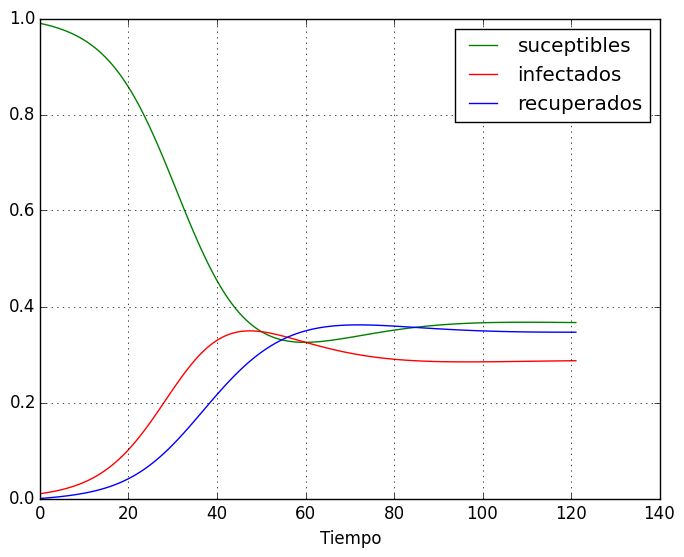

  2.911486 seconds (79.39 M allocations: 1.295 GB, 3.22% gc time)


In [18]:
N = 1.
I0 = N/100
R0 = 0.0
S0 = N-I0-R0
ti = 0.
tf = 120.
beta = 0.2
gamma = 0.07
mu = 0.003
f = 0.055

@time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta ,mu,f);

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
grid()
xlabel("Tiempo")
legend()
show()

  3.031840 seconds (94.26 M allocations: 1.526 GB, 3.35% gc time)
  2.875709 seconds (90.80 M allocations: 1.470 GB, 3.37% gc time)
  2.860705 seconds (88.72 M allocations: 1.437 GB, 3.37% gc time)
  3.075053 seconds (87.33 M allocations: 1.414 GB, 3.09% gc time)
  2.792422 seconds (85.95 M allocations: 1.392 GB, 3.33% gc time)


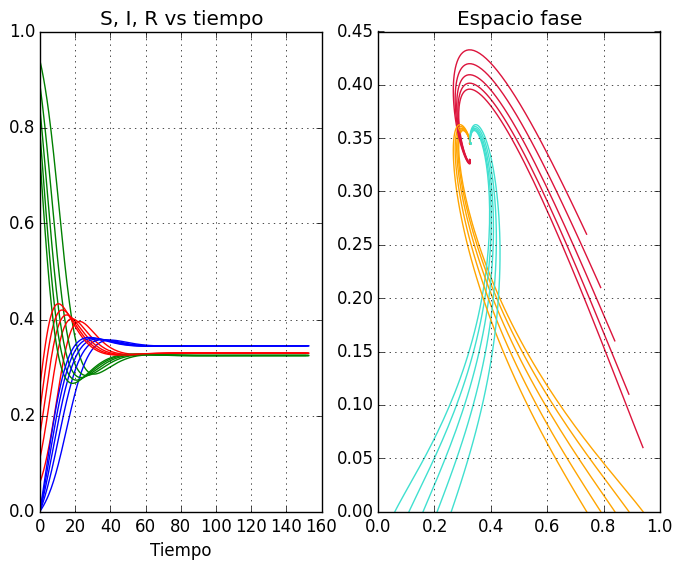

In [19]:
p = 5

for j in 1:p
    
    N = 1.
    I0 = N/100+0.05*j
    R0 = 0.
    S0 = N-I0-R0
    ti = 0.
    tf = 150.
    beta = 0.28
    gamma = 0.09
    mu = 0.001
    f = 0.085


    @time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta, mu, f);

    subplot(1,2,1)
    plot(t,s, color = "green", label = "Suceptibles")
    plot(t,i, color = "red", label = "Infectados")
    plot(t,r, color = "blue", label = "Recuperados")
    grid()
    title("S, I, R vs tiempo")
    xlabel("Tiempo")
    
    subplot(1,2,2)
    plot(s,i, color="crimson")
    plot(s,r,color="orange")
    plot(i,r,color="turquoise")
    grid()
    title("Espacio fase")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

end

In [62]:
#S0=zeros(5.)
I0=zeros(5)

for j in 1:5
    N = 1.
    I0[j] = N/100+0.05*j
    R0 = 0.
    #S0[j] = N-I0-R0
    ti = 0.
    tf = 100.
    beta = 0.28
    gamma = 0.09
    mu = 0.001
    f = 0.085

end   

@time t1,s1,i1,r1 = integrador_kermack_SIRS(N, I0[1], R0, ti, tf, gamma, beta, mu, f);
@time t2,s2,i2,r2 = integrador_kermack_SIRS(N, I0[2], R0, ti, tf, gamma, beta, mu, f);
@time t3,s3,i3,r3 = integrador_kermack_SIRS(N, I0[3], R0, ti, tf, gamma, beta, mu, f);
@time t4,s4,i4,r4 = integrador_kermack_SIRS(N, I0[4], R0, ti, tf, gamma, beta, mu, f);
@time t5,s5,i5,r5 = integrador_kermack_SIRS(N, I0[5], R0, ti, tf, gamma, beta, mu, f);

  2.837331 seconds (79.71 M allocations: 1.291 GB, 4.46% gc time)
  2.792451 seconds (76.93 M allocations: 1.246 GB, 4.17% gc time)
  2.544100 seconds (74.86 M allocations: 1.212 GB, 4.40% gc time)
  2.354396 seconds (73.47 M allocations: 1.190 GB, 4.51% gc time)
  2.386965 seconds (72.78 M allocations: 1.179 GB, 4.62% gc time)


In [110]:
using PyCall
@pyimport matplotlib.animation as anim 

t1data=t1
x1data=s1
y1data=i1

t2data=t2
x2data=s2
y2data=i2

t2data=t2
x2data=s2
y2data=i2

t3data=t3
x3data=s3
y3data=i3

t4data=t4
x4data=s4
y4data=i4

t5data=t5
x5data=s5
y5data=i5


xmin=minimum([x1data,x2data,x3data,x4data,x5data])
ymin=minimum([y1data,y2data,y3data,y4data,y5data])
xmax=maximum([x1data,x2data,x3data,x4data,x5data])
ymax=maximum([y1data,y2data,y3data,y4data,y5data])
#Use External Viewer for Animation
pygui(true)


#Construct Figure and Plot Data
fig = figure() 
    ax = axes(xlim = (xmin,xmax),ylim=(ymin,ymax)) #esto define los límites de los ejes

global line1 = ax[:plot]([],[],"r-")[1]
global line2 = ax[:plot]([],[],"r-")[1]
global line3 = ax[:plot]([],[],"r-")[1]
global line4 = ax[:plot]([],[],"r-")[1]
global line5 = ax[:plot]([],[],"r-")[1]
global p1 = ax[:plot]([],[],"or")[1]
global p2 = ax[:plot]([],[],"or")[1]
global p3 = ax[:plot]([],[],"or")[1]
global p4 = ax[:plot]([],[],"or")[1]
global p5 = ax[:plot]([],[],"or")[1]


function init()
    global line1
    global line2
    global line3
    global line4
    global line5
    global p1
    global p2
    global p3
    global p4
    global p5
    line1[:set_data]([],[])
    line2[:set_data]([],[])
    line3[:set_data]([],[])
    line4[:set_data]([],[])
    line5[:set_data]([],[])
    p1[:set_data]([],[])
    p2[:set_data]([],[])
    p3[:set_data]([],[])
    p4[:set_data]([],[])
    p5[:set_data]([],[])
    return (line1,line2,line3,line4,line5,p1,p2,p3,p4,p5)
end

step=1
#step=min(1,length(t1),length(t2),length(t3),length(t4),length(t5)) 
minlent=min(length(t1),length(t2),length(t3),length(t4),length(t5))

function animate(i)
    k = i + 1
    global line1
    global line2
    global line3
    global line4
    global line5
    global p1
    global p2
    global p3
    global p4
    global p5   
    
    line1[:set_data](x1data[1:(step*k)],y1data[1:(step*k)])
     line2[:set_data](x2data[1:(step*k)],y2data[1:(step*k)])
     line3[:set_data](x3data[1:(step*k)],y3data[1:(step*k)])
     line4[:set_data](x4data[1:(step*k)],y4data[1:(step*k)])
     line5[:set_data](x5data[1:(step*k)],y5data[1:(step*k)])
    p1[:set_data]([x1data[step*k]],y1data[step*k])
    p2[:set_data]([x2data[step*k]],y2data[step*k])
    p3[:set_data]([x3data[step*k]],y3data[step*k])
    p4[:set_data]([x4data[step*k]],y4data[step*k])
    p5[:set_data]([x5data[step*k]],y5data[step*k])
    
    return (line1,line2,line3,line4,line5,p1,p2,p3,p4,p5)
end


#Call the animator.
myanim = anim.FuncAnimation(fig, animate, init_func=init, frames=ifloor(minlent/step), interval=20)

#este comando requiere instalar ffmpeg para su respectivo sistema operativo. Descargar en http://ffmpeg.org/download.html
myanim[:save]("Animaciones/_IvsS.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

In [2]:

#displays the video from the previously saved file. This has the advantage of keeping the notebook size small
display("text/html", html_video("Animaciones/_IvsS.mp4"))

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAo4ltZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCByMjY5NCAzYjcwNjQ1IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlyaWdodCAyMDAzLTIwMTYgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEOtliIQAM//+9uy+BTX9n9CXESzF2kpwPiqkgIB3NMAAAAMAAAMAAAMAA0AdraId2gkE0AAAAwAL8AKKl/3We5nzAJffvNG2j0cDjHm63xYBOR7oMKk0zAiN/MHdBfynKeldyS9TwpI70RoxrVMTZPGLFVKBCDSqUTG8Pn+G7SVUIZ99s/P9r+UBfAuLiPMC5WPyBDB4Vn+SUgofb6qt5w1qKA9MQAPH6yISvGU0S7M9NIH5pgQHlI9d3+ZCzugUZGH6FDcF/dwS8dwaNqO70B2O/qgymRYtaBEUtyMO5m2sZz0eLNQXO8DqrFAlBYea46RL8aMPQixpvH0GxWyuVNv3thHV3UXeXjE++1MPu44Vk6efLPBujPnyv6m+FeCTC0koPgqeVo63ZeBy8kb2gu7jf8cxPBi6Zy+qJqMu0s2VPcxRt1Q28zQfxnXDn2AyTWfn0mR7a6QJo2UKh09tzaIloEkQnC/y0dJDAKkz+KhZk93DSMng+qgWXeREFAhq5vmmNUWC0eptdVxdA32rq5von+k42vuB3YdPFc7QckTDFZIi5vMvtib9qxAyIpjJWkj0WSG6ClbSTuiCpvlnlkvZjdlSYM/pKZTZ+Jk+v9SDxVHKERof+IIOPbT33zDfaEzeNfH+jYENBuLIpH6KGQCDjq6EGJ18JrR4S054xlzNj2lo0yNP+WFvredGIjlOZRL+1u8QEpeWXuMwafb5txict1dLy+uq4IUyyjBRPU6OhRSEqnyklN12Msm438Vnf4xOr6YIGenqjLPz/eML7ad2PxWuxZzYKCmdJAsnECww6PCTSIpnPMflz8oIav5WNEnCeCsb6X4F9vBmdt8kOsYDu0P7OdZG0TIK3EEtQbtDeOkoEvmTHkpXNLRJmy1dD70qh9HTSoZCCgJhLJTlfytiMsNNG9JxVq9SvL2pOuhp93++UiG8qglID1knrftDzyCmiGg13OKDOAAAAwAAZR9DX5thmWPNJyp7h3KqCyU13RiwcSoeUCTa2AAI7DJSABOo34CVGT8MtjACEltWEKHGdFoZe5LcUvoO31kq7APEAlVTAWwIj0tRB7Lalme5sBVcfShAvurwhMyHL74Dc7gQwxAAfxe7AeeZKDIBDvuGnyD+ZX05b1snE5J/7w3+W5X44ZXo/dADgbQ7PD8yNHT7akB9U8PsDuFYOr6iMTQNYa97gwJOkb9sFpUEsmTYyB9Xw2cGzB+LgK43TVr/2xJRgp0CRSrHoP89SNN48PhMaO5gHCIWDKSXfbZIAvI4mx+2OGjnpgPMjIEu6FTIHgqde9/0qMWVnRe1DqnbxN8dXDhbUDh19Qs8jq+CISNH9XCUYF7OWIuCEpo0Wjv5TiS7AoOZcXgAr/yaPfXqXoJLcEXPNiNpSWqt0KO50Uf4BqDjadpzSj4APtBeIn7AdwAABQ7S+XG2iLbMwQ9bV9khZgW8HDNT1oW+3h4lgGCBFAChXK34DGN5/NfNCUV/dlPGBUoLSkyLWMHlQrOR4bpUwciZYB2hO2YqB5/UEkUhcvnBwtPjroyMYlzLd49vRQe0AAFvmR5utZD457+TDCqZgs3LDNNvjYTJD8g/YBYadyPAjR2fuZTERP0TajR9gxTKiBlUpJBadBVx6VENZQuGIe5CyczAgvNd9NOIJhnjIvJRubAQBCsgTSQFREjiJ7w+T9GdujLTX24KuF0V27hc5P9Tv+iLc0s1PBCBKaIaLypeUPKRbnXgKOS69sEDAHZo6xdkADiI+phE1eLE5rNGBPz4H/nqYLOEvR6zYDrVUNhkA32rBo14gfBi5AcW6GY+IFl8eyk5rGUWPaf0mc+ahMWA0dMW/GTlVnskmilnDIWXicJcAAAZyYSz4H0uS3g5Hl9su3VWBtu+305nSePYAj4COgZwBIC3TzrjUnkm9r32ancS0fvhALczLppk2bsP7uKBhlDZ4QvkAZk/XxJ9IF9vueyf1diVydpic5/X4YCJpRzSPvaRmleA8AcnD7WHL2c+m5gdjIzHeeW3ar0s32NF0CUcEaN48h4aNLt5+Cx8UmjeZ0Eq/C7Locg+8IY6HzEXkKW8ZY8oyOOGm6ASHS4Lr1R+zzIuDODMcZLIFYIIRNHa92iXEwzO1seQgYfZ7StL43duPovUb/S2ppxUNqEpMK81xhetbXFsyd7QbM2dgdbaxDwKTwRG/i4CvHvYwFj+E8PobrUGFXR4TAyPo8KNByT7uJLBE2PLLnDwTKeLlDTwQ2nmRYsGJHzeWehvu3Lo73yNK/gSBzHaK/fy11svKwz7v/+a1au6obdtZdPkPOJ6E7VlAX2jVlUvugH+q1PJ9VK0lPwexkVjZ/W/Iul7Wf3HXZF4q+UPXd1jOA6Fg64AQbAABq9fXD1e/ypajYawhp4CD+WQ3GcJ2qs9U643aIPwBDAT/kC2AGkqgZQWdj9Dmq5a1Xe+P54GkBqYS7tjYmYNuEFBlFs93N46a1zqs3jnXUyJlxfmIIaSSR7AxYDiPX51iv/uZj9lxxr9M4ZZ5x1bxKT9w+Xw5ZK/syjv/Dv9OjbSEpkiG9thtyrzt9/ep6sbIWCRn02ZhVQU3E9lmSTfKtGs9YbdH2VDBa0lok++nZ8Z0S2gE76e5uUjzmIUxqARwk/s6iTxChj1/8n2jhqWl2BG1IKp+gElU+eKBDVVGth85OHagX99kYrZvHOe5Ir6bcr+q9hXzhZRxc5cjG23hfEjbscFBKXVlMHxofAMJd4krpCOM8DqUkFKXzSFZJPPdDZHWknLKiVnTduXmHzckByq+IwlAM9J6hvf+oIRw9wSQU3KFvWX2tawJ9ckBjwvK7vJK10R36nJf//9m2aN6T3mlNB+51IRzOQPsC1oBxzvQTaKJXnw6I4XAAAvOYL57Z5XHdGcu5wM/q58JB5wvAYuzEgSDLXIAAGGMDQAF+iQHPSepuPxzYvci+QN08ilKiT8yNvMVl5

 in depwarn at deprecated.jl:73
 in base64 at deprecated.jl:30
 in html_video at In[1]:3
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at C:\Users\ARTURO\.julia\v0.4\IJulia\src\execute_request.jl:183
 in eventloop at C:\Users\ARTURO\.julia\v0.4\IJulia\src\IJulia.jl:143
 in anonymous at task.jl:447
while loading In[2], in expression starting on line 3


# Para K especies (K=3)

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.


$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$

In [16]:
eps_abs = 1e-20

1.0e-20

In [17]:
function coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fr = F2(gamma[i], Ti[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3 (generic function with 2 methods)

In [18]:
function k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
    end
    return t,s,i,r
end

k_3 (generic function with 1 method)

Integramos ahora con condiciones iniciales y en un intervalo de tiempo razonable.

In [19]:
N1 = .5
N2 = .3
N3 = .2
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250.
;

In [20]:
beta = rand(3,3)/3
gamma = rand(3)/8
;

In [21]:
@time t3, s3, i3, r3 = k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma, beta);

  2.033801 seconds (42.84 M allocations: 724.674 MB, 3.07% gc time)


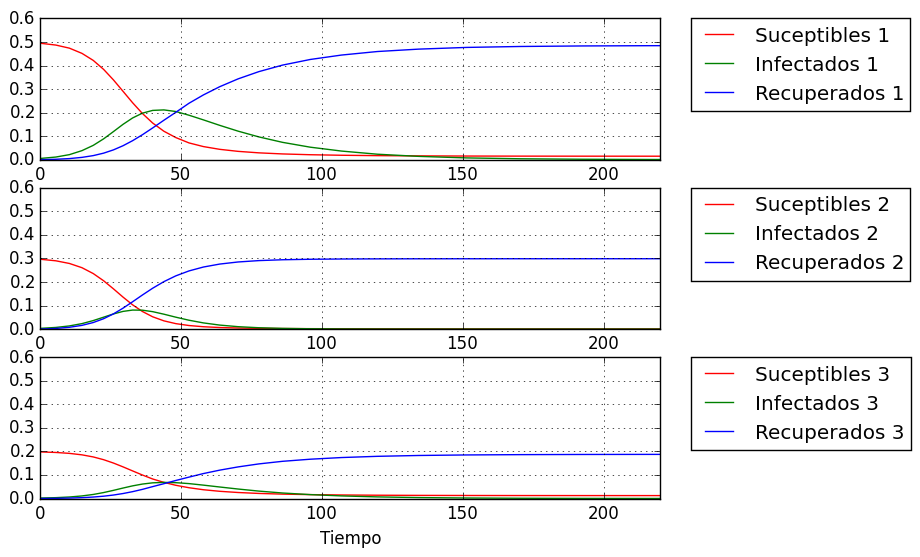

In [22]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axis([0, 220, 0, 0.6])
    grid()
end
xlabel("Tiempo")
show()

In [23]:
suma = 0
for k = 1:3
    suma += s3[k]+i3[k]+r3[k]
end
dump(suma)

Array(Float64,(29,)) [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]


Como vemos, la población total $N$ se mantiene constante.

Ahora que nuestro integrador funciona, complicamos las cosas e implementaremos un factor de reincidencia $\phi$ para cada una de las especies.

$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3 + \phi_i R_i$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i - \phi_i R_i$$

Modificamos un poco nuestro código anterior para lograrlo. Definimos una función para calcular los coeficientes y nuestro integrador.

In [24]:
function coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    F3(phi_i,R) = phi_i*R
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fs += F3(phi[i],Tr[i])
            fr = F2(gamma[i], Ti[i])-F3(phi[i],Tr[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3_reincidencia (generic function with 2 methods)

In [25]:
function k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta, phi)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    n_iteracion = 1
    
    while t0 < tf && n_iteracion < 2000
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
        n_iteracion += 1
    end
    return t,s,i,r
end

k_3_reincidencia (generic function with 1 method)

Definimos nuestras matrices de coeficientes. $\beta_{ij}$ es la matriz de coeficientes de transmisión, $\gamma_i$ la de coeficientes de recuperación (con $1/\gamma_i$ el tiempo promedio de recuperación) y $\phi_i$ la matriz de reincidencia o re-contagio. Al no tener datos experimentales, tomamos valores que están de acuerdo con la teoría.

In [26]:
# Hacemos 3 matrices de prueba con valores pre-establecidos.

phi1 = ([0.011980782470983145,0.0122242866833574,0.12049916741165438])
gamma1 = ([0.0920466,0.0690204,0.0427661])
beta1 = [0.138933 0.0147811 0.0747647; 0.0243735 0.116977 0.0574383; 0.183494 0.109088 0.283322]
;

In [27]:
# Tomamos valores aleatorios para nuestros parámetros.

beta = rand(3,3)/3
gamma = rand(3)/11
phi = rand(3)/80
;

Definimos ahora valores iniciales y el intervalo de tiempo para que nuestro integrador pueda operar.

In [28]:
N1 = 1.
N2 = 1.
N3 = 1.
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 700.
;

In [29]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma1, 
beta1, phi);
length(t3)

  3.434223 seconds (77.37 M allocations: 1.262 GB, 3.12% gc time)


52

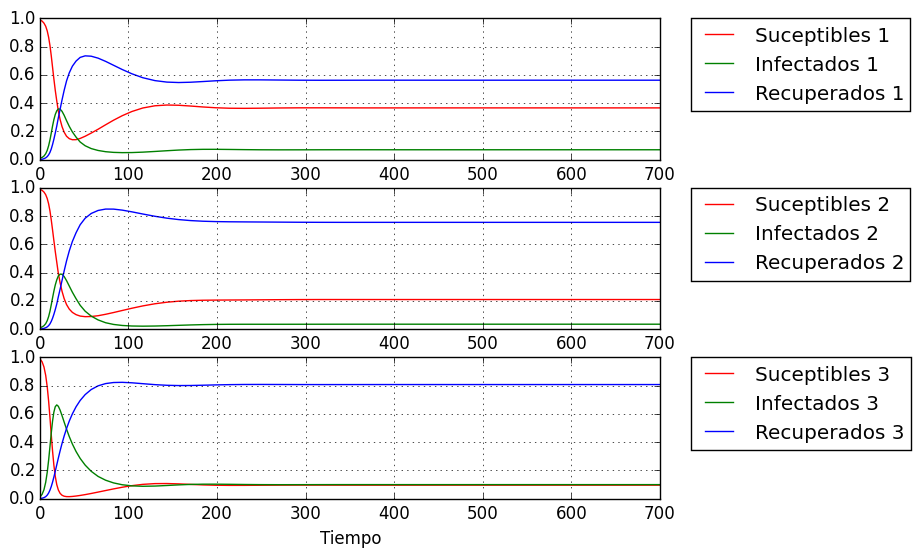

In [30]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end
xlabel("Tiempo")
show()

Muchos diagramas de fase a lo tonto.

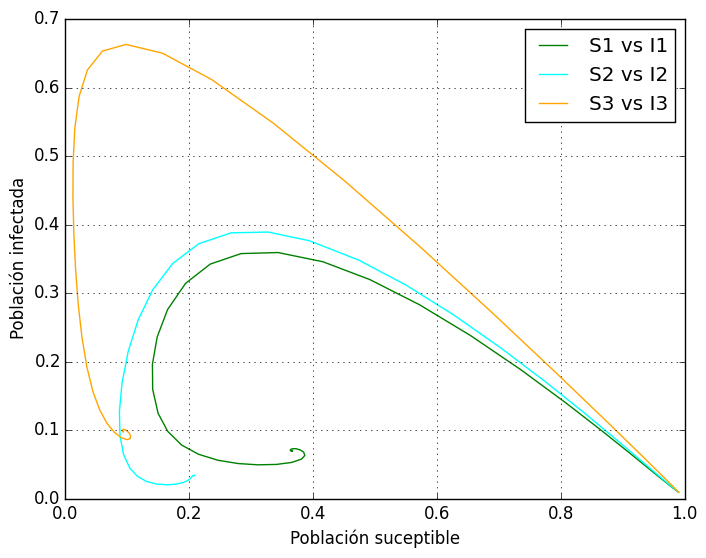

In [31]:
plot(s3[1],i3[1], color = "green", label = "S1 vs I1")
# plot(s3[1],i3[2], color = "red", label = "S1 vs I2")
# plot(s3[1],i3[3], color = "blue", label = "S1 vs I3")
plot(s3[2],i3[2], color = "cyan", label = "S2 vs I2")
# plot(s3[2],i3[3], color = "magenta", label = "S2 vs I3")
plot(s3[3],i3[3], color = "orange", label = "S3 vs I3")
# plot(r3[1],i3[1], color = "peru", label = "R3 vs I3")
legend()
grid()
xlabel("Población suceptible")
ylabel("Población infectada")
show()

Ahora queremos empezar a ver la dinámica si perturbamos las condiciones iniciales. Como ejemplo ilustrativo, lo haremos sobre la población 1 de nuestro problema anterior. Declaramos de nuevo nuestros parámetros.

In [32]:
N1 = 1.
N2 = 1.
N3 = 1.
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 450.
;

Ahora variamos la condición inicial para ver cómo se comporta el sistema.

In [33]:
for i in 1:20
    I0_1 += 0.003*i
    @time t3, s3, i3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, 
    Gamma, Beta, Phi);    
    plot(s3[1],i3[1], color = "green")
end
grid()
title("S1 vs I1")
xlabel("Población 1 suceptible")
ylabel("Población 1 infectada")
show()

LoadError: LoadError: UndefVarError: Gamma not defined
while loading In[33], in expression starting on line 1

... no parece muy interesante. ¿Qué pasará ahora si perturbamos el sistema de equilibrio?
Sabemos que el sistema de ecuaciones diferenciales para el modelo tiene como solución de equilibrio la trivial, pero el modelo permite una solución de equilibrio no nula: a esta le llamamos la solución de *equilibrio endémico*. Utilizamos la paquetería externa NLsolve para encontrar estos puntos de equilibrio endémico.

In [51]:
using NLsolve

In [52]:
# Tomamos valores aleatorios para nuestros parámetros.

beta = rand(3,3)/3
gamma = rand(3)/10
phi = rand(3)/450
;

In [53]:
Beta = [0.134526   0.0449375  0.283664; 0.0322725  0.319525   0.253701; 0.282935   0.239162   0.113143]
Gamma = [0.0465392; 0.0549394; 0.0497149]
Phi = [0.00212581; 0.00188398; 0.00152644]
;

$x[1,2,3,4,5,6,7,8,9] = (S1,S2,S3,I1,I2,I3,R1,R2,R3) $

In [54]:
function soluciones!(x, svec)
    svec[1] = 0
    svec[2] = 0
    svec[3] = 0
    ### Para S1, S2, S3
    for j = 1:3
        for k = 1:3
            svec[j] += -beta_1[j,k]*x[j]*x[k+3]
        end
    svec[j] += phi_1[j]*x[j+6]
    end
    ### Para R1, R2, R3
    for j = 1:3
        svec[j+6] = gamma_1[j]*x[j+3]-phi_1[j]*x[j+6]
    end
    ### Para I1, I2, I3
    svec[4] = N1-x[1]-x[4]-x[7]
    svec[5] = N2-x[2]-x[5]-x[8]
    svec[6] = N3-x[3]-x[6]-x[9]
end

soluciones! (generic function with 1 method)

In [55]:
x_inicial = 0.3*ones(9)
resultados = nlsolve(soluciones!,x_inicial)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3]
 * Zero: [0.1338879795167064,0.019002774193362867,0.10042512441172173,0.12005514508383607,0.03390608055816082,0.07472443753296855,0.7460568753994575,0.9470911452484763,0.8248504380553098]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

In [56]:
S_estable_1 = resultados.zero[1]
S_estable_2 = resultados.zero[2]
S_estable_3 = resultados.zero[3]
I_estable_1 = resultados.zero[4]
I_estable_2 = resultados.zero[5]
I_estable_3 = resultados.zero[6]
R_estable_1 = resultados.zero[7]
R_estable_2 = resultados.zero[8]
R_estable_3 = resultados.zero[9]
tiempo_inicial = 0.
tiempo_final = 2500.
;

In [57]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_estable_1, I_estable_2, 
I_estable_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
gamma_1, beta_1, phi_1);

  5.267167 seconds (148.04 M allocations: 2.393 GB, 3.57% gc time)


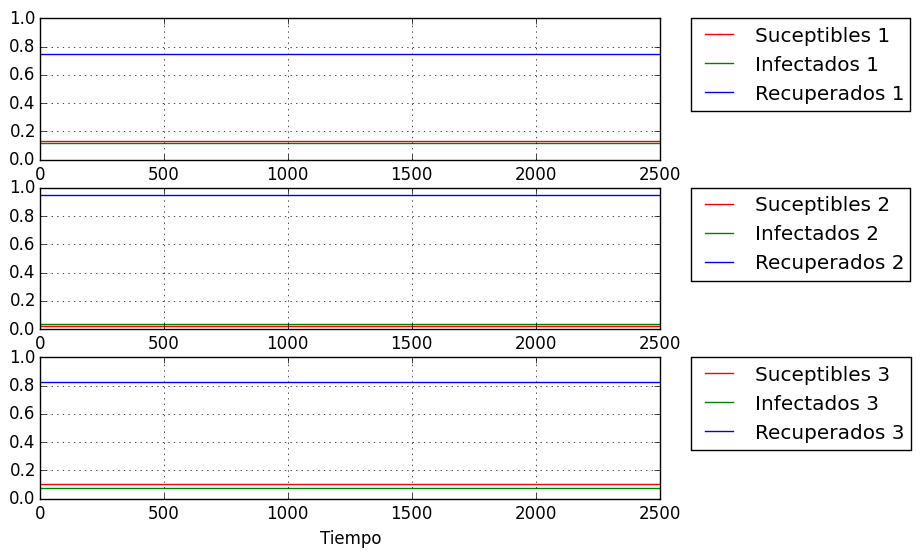

In [58]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end
xlabel("Tiempo")
show()

Ahora perturbamos las condiciones iniciales (para todas las poblaciones infectadas) y vemos cómo se comporta el sistema.

  0.865995 seconds (21.15 M allocations: 350.075 MB, 3.37% gc time)
  1.524524 seconds (37.77 M allocations: 625.134 MB, 3.29% gc time)
  1.592711 seconds (40.79 M allocations: 675.144 MB, 3.31% gc time)
  1.571159 seconds (42.30 M allocations: 700.149 MB, 3.43% gc time)
  1.462525 seconds (43.81 M allocations: 725.154 MB, 3.61% gc time)
  1.530928 seconds (45.32 M allocations: 750.159 MB, 3.73% gc time)
  1.565911 seconds (46.83 M allocations: 775.164 MB, 3.53% gc time)
  1.672847 seconds (48.34 M allocations: 800.174 MB, 3.60% gc time)


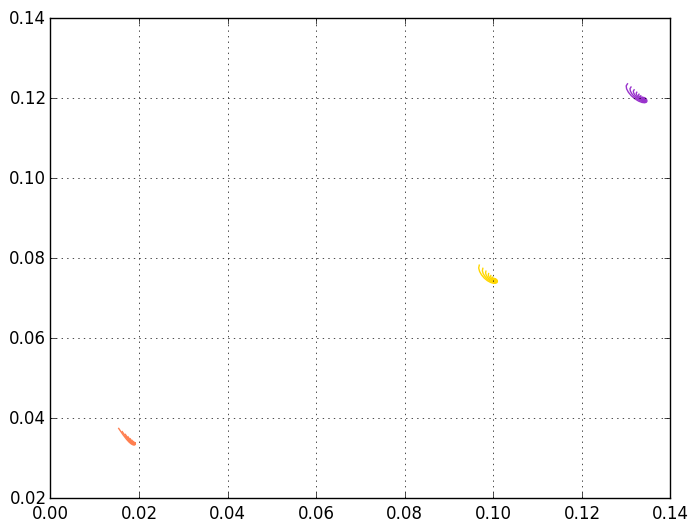

  1.674163 seconds (49.85 M allocations: 825.179 MB, 3.65% gc time)


In [59]:
eps_abs = 1e-30

I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3
tiempo_inicial = 0.
tiempo_final = 500.

for i in 0:8
    I_perturbado_1 += 0.0001*i
    I_perturbado_2 += 0.0001*i
    I_perturbado_3 += 0.0001*i
    
    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma_1, beta_1, phi_1);  
    
    colores = ["darkorchid", "coral", "gold"]
    
    for k in 1:3
#     k = 1
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

Parámetros beta, gamma y phi bonitos.

In [60]:
Beta = [0.134526   0.0449375  0.283664; 0.0322725  0.319525   0.253701; 0.282935   0.239162   0.113143]
Gamma = [0.0465392; 0.0549394; 0.0497149]
Phi = [0.00212581; 0.00188398; 0.00152644]
;

In [61]:
I_crit_1 = I_perturbado_1
I_crit_2 = I_perturbado_2
I_crit_3 = I_perturbado_3
;

  2.196161 seconds (63.45 M allocations: 1.026 GB, 3.64% gc time)
  2.385476 seconds (67.98 M allocations: 1.099 GB, 3.67% gc time)
  2.556837 seconds (72.51 M allocations: 1.172 GB, 3.55% gc time)
  2.917840 seconds (77.04 M allocations: 1.245 GB, 3.42% gc time)
  3.244376 seconds (80.07 M allocations: 1.294 GB, 3.33% gc time)
  3.551895 seconds (83.09 M allocations: 1.343 GB, 3.07% gc time)
  3.969663 seconds (86.11 M allocations: 1.392 GB, 3.09% gc time)
  3.337630 seconds (89.13 M allocations: 1.441 GB, 3.34% gc time)
  3.599052 seconds (92.15 M allocations: 1.490 GB, 3.51% gc time)
  3.790463 seconds (95.17 M allocations: 1.538 GB, 3.46% gc time)
  3.826828 seconds (98.19 M allocations: 1.587 GB, 3.42% gc time)
  4.744285 seconds (99.70 M allocations: 1.612 GB, 3.02% gc time)
  4.162027 seconds (102.72 M allocations: 1.661 GB, 3.48% gc time)
  4.454045 seconds (104.24 M allocations: 1.685 GB, 3.40% gc time)
  6.105503 seconds (107.26 M allocations: 1.734 GB, 2.84% gc time)
  3.940

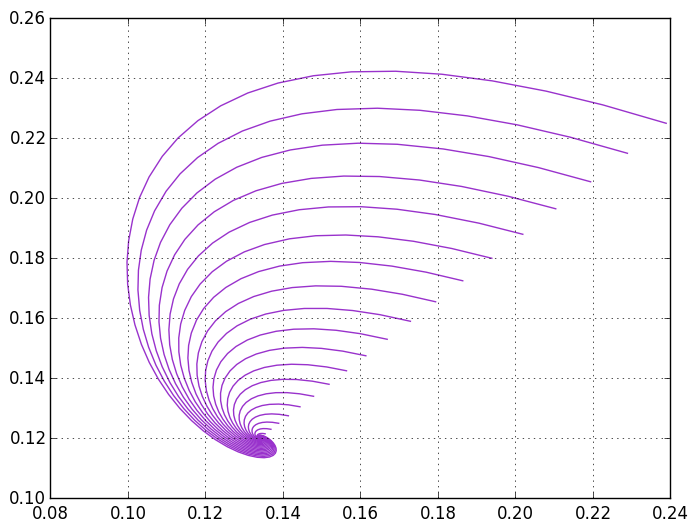

  4.188817 seconds (117.83 M allocations: 1.905 GB, 3.60% gc time)


In [62]:
eps_abs = 1e-39

I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3

R_perturbado_1 = R_estable_1
R_perturbado_2 = R_estable_2
R_perturbado_3 = R_estable_3

for i in 1:20
    I_perturbado_1 += 0.0005*i
#     I_perturbado_2 += 0.005*i
#     I_perturbado_3 += 0.001*i
    
    R_perturbado_1 += -0.001*i
#     R_perturbado_2 += -0.005*i
#     R_perturbado_3 += -0.003*i
    

    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_perturbado_1, R_perturbado_2, R_perturbado_3,tiempo_inicial, tiempo_final, 
    gamma_1,beta_1,phi_1);  
    colores = ["darkorchid", "coral", "gold"]
    for k = 1:1
#         subplot(3,1,k)
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

In [46]:

str ="t1"
for i in 2:20
    str=join([str,"t$i"],",")
end

length(eval(parse(str))[20])
maxlen=0
minlen=10^6
for i in 1:20
    if length(eval(parse(str))[i])>maxlen
        maxlen=length(eval(parse(str))[i])
    end
    if length(eval(parse(str))[i])<minlen
        minlen=length(eval(parse(str))[i])
    end
    
end
maxlen,minlen

LoadError: LoadError: UndefVarError: t1 not defined
while loading In[46], in expression starting on line 7

  2.100720 seconds (63.45 M allocations: 1.026 GB, 3.88% gc time)
  2.256481 seconds (67.98 M allocations: 1.099 GB, 3.89% gc time)
  2.453032 seconds (72.51 M allocations: 1.172 GB, 3.77% gc time)
  3.641715 seconds (77.04 M allocations: 1.245 GB, 3.07% gc time)
  2.607049 seconds (80.07 M allocations: 1.294 GB, 3.89% gc time)
  2.736067 seconds (83.09 M allocations: 1.343 GB, 3.92% gc time)
  3.011532 seconds (86.11 M allocations: 1.392 GB, 3.81% gc time)
  3.258092 seconds (89.13 M allocations: 1.441 GB, 4.09% gc time)
  3.229173 seconds (92.15 M allocations: 1.490 GB, 4.08% gc time)
  3.122010 seconds (95.17 M allocations: 1.538 GB, 3.92% gc time)
  3.435137 seconds (98.19 M allocations: 1.587 GB, 4.19% gc time)
  3.578380 seconds (99.70 M allocations: 1.612 GB, 3.76% gc time)
  3.376913 seconds (102.73 M allocations: 1.661 GB, 4.00% gc time)
  3.416993 seconds (104.24 M allocations: 1.685 GB, 3.99% gc time)
  3.833091 seconds (107.26 M allocations: 1.734 GB, 3.77% gc time)
  3.564

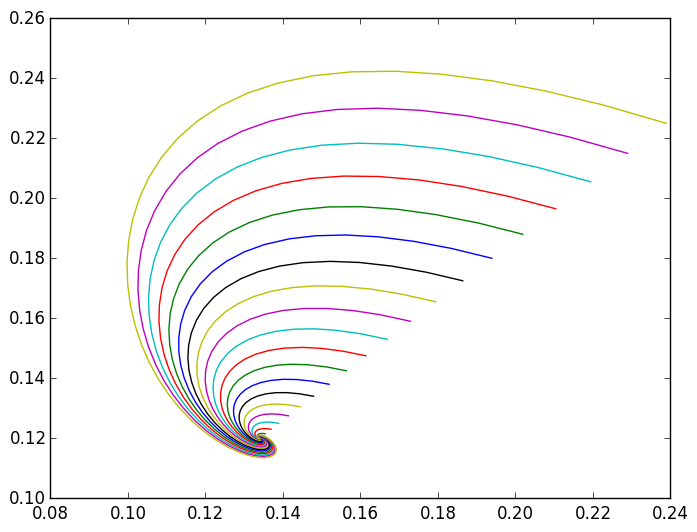

In [64]:
eps_abs = 1e-39

I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3

R_perturbado_1 = R_estable_1
R_perturbado_2 = R_estable_2
R_perturbado_3 = R_estable_3

for j in 1:20
    I_perturbado_1 += 0.0005*j  
    R_perturbado_1 += -0.001*j

    @time eval(parse("t$j,s$j,i$j,r$j = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2,I_perturbado_3, R_perturbado_1, R_perturbado_2, R_perturbado_3,tiempo_inicial, tiempo_final, gamma_1,beta_1,phi_1);")) 
    colores = ["darkorchid", "coral", "gold"]
    eval(parse("plot(s$j[1],i$j[1])"))
end

#grid()
#show()

In [82]:

using PyCall
@pyimport matplotlib.animation as anim 

for j in 1:20
    eval(parse("tdata$j=t$j")) 
    eval(parse("xdata$j=s$j[1]")) 
    eval(parse("ydata$j=i$j[1]")) 
end

strt ="[tdata1"
strx="[xdata1"
stry="[ydata1"
for j in 2:20
    strt=join([strt,"tdata$j"],";")
    strx=join([strx,"xdata$j"],";")
    stry=join([stry,"ydata$j"],";")   
end
strt=join([strt,"]"])
strx=join([strx,"]"])
stry=join([stry,"]"])

xmax=maximum(eval(parse(strx)))
ymax=maximum(eval(parse(stry)))
xmin=minimum(eval(parse(strx)))
ymin=minimum(eval(parse(stry)))


0.11357802970061848

In [ ]:
#Use External Viewer for Animation
pygui(true)

#Construct Figure and Plot Data
fig = figure() 
    ax = axes(xlim = (xmin,xmax),ylim=(ymin,ymax)) #esto define los límites de los ejes

global line1 = ax[:plot]([],[],"b-")[1]
global p1 = ax[:plot]([],[],"ob")[1]

for j in 2:20
    eval(parse("line$j=line1")) 
    eval(parse("p$j=p1"))
end

In [84]:



function init()
    for j in 1:20
        eval(parse("global line$j"))    
    end
    
    for j in 1:20
        eval(parse("global p$j"))
    end
    
    for j in 1:20
        eval(parse("line$j[:set_data]([],[])"))
    end
    
    for j in 1:20
        eval(parse("p1[:set_data]([],[])"))
    end    
         linestr="line1"
        ptstr="p1"
        for j in 2:20
            linestr=join([linestr,"line$j"],",")
            ptstr=join([ptstr,"p$j"],",")
        end
        return (eval(parse(join([linestr,ptstr],","))))
end


step=5
#step=min(1,length(t1),length(t2),length(t3),length(t4),length(t5)) 
minlent=10^6
    for j in 1:10
        if length(eval(parse("tdata$j")))<minlent
            minlent=length(eval(parse("tdata$j")))
    end
end
    
function animate(i)
    k = i + 1
    for j in 1:20
        eval(parse("global line$j"))    
    end
    
    for j in 1:20
        eval(parse("global p$j"))
    end
    
        for j in 1:20
            line1 
        end
        
        for j in 1:20
            eval(parse("line$j[:set_data](xdata$j[1:(step*k)],ydata$j[1:(step*k)])"))
        end
        
        for j in 1:20
            eval(parse("p$j[:set_data]([xdata$j[step*k]],ydata$j[step*k])"))
        end

        linestr="line1"
        ptstr="p1"
        for j in 2:20
            linestr=join([linestr,"line$j"],",")
            ptstr=join([ptstr,"p$j"],",")
        end
        
        return (eval(parse(join([linestr,ptstr],","))))
end


#Call the animator.
myanim = anim.FuncAnimation(fig, animate, init_func=init, frames=floor(Integer,minlent/step), interval=20)

#este comando requiere instalar ffmpeg para su respectivo sistema operativo. Descargar en http://ffmpeg.org/download.html
myanim[:save]("Animaciones/3esp.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.RuntimeError'>
RuntimeError('Julia exception: UndefVarError(:k)',)
  File "C:\Program Files\Anaconda\lib\site-packages\matplotlib\animation.py", line 766, in save
    anim._draw_next_frame(d, blit=False)
  File "C:\Program Files\Anaconda\lib\site-packages\matplotlib\animation.py", line 803, in _draw_next_frame
    self._draw_frame(framedata)
  File "C:\Program Files\Anaconda\lib\site-packages\matplotlib\animation.py", line 1106, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)

while loading In[84], in expression starting on line 91

In [49]:
for i in 1:7
    I_perturbado_1 += 0.001*i
    I_perturbado_2 += 0.005*i
    I_perturbado_3 += 0.01*i

    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma, beta, phi);  

    colores = ["darkorchid", "coral", "gold"]
    plot(s3[1],i3[1], color = colores[1])
end
grid()
show()

LoadError: LoadError: UndefVarError: I_perturbado_1 not defined
while loading In[49], in expression starting on line 1

ESTO SE DESCONTROLÓ

Los parámetros de abajo son para las curvas de arriba, las delgaditas

In [50]:
gamma_1 = [0.0382117; 0.0378735; 0.0425732]
phi_1 = [0.00614901; 0.00135588; 0.00385677]
beta_1 = [0.159791  0.143463  0.136713; 0.330302  0.152469  0.304485; 0.160856  0.30528   0.0269721]
;